# Amazon Forecast 공부 및 정리 - NTP , DeepAR 

## Time series forecasting using unstructured data with Amazon Forecast and the Amazon SageMaker Neural Topic Model 정리 및 공부

### 출처 : [https://aws.amazon.com/ko/blogs/machine-learning/time-series-forecasting-using-unstructured-data-with-amazon-forecast-and-the-amazon-sagemaker-neural-topic-model/](https://aws.amazon.com/ko/blogs/machine-learning/time-series-forecasting-using-unstructured-data-with-amazon-forecast-and-the-amazon-sagemaker-neural-topic-model/) 

As the volume of unstructured data such as text and voice continues to grow, businesses are increasingly looking for ways to incorporate this data into their time series predictive modeling workflows. One example use case is transcribing calls from call centers to forecast call handle times and improve call volume forecasting. In the retail or media industry, companies are interested in using related information about products or content to forecast popularity of existing or new products or content from unstructured information such as product type, description, audience reviews, or social media feeds.

However, combining this unstructured data with time series is challenging because most traditional time series models require numerical inputs for forecasting. In this post, we describe how you can combine Amazon SageMaker with Amazon Forecast to include unstructured text data into your time series use cases.

Solution overview
For our use case, we predict the popularity of news articles based on their topics looking forward over a 15 day horizon. You first download and preprocess the data and then run the NTM algorithm to generate topic vectors. After generating the topic vectors, you save them and use these vectors as a related time series to create the forecast.

The following diagram illustrates the architecture of this solution.



텍스트 및 음성과 같은 구조화되지 않은 데이터의 양이 계속 증가함에 따라, 비즈니스는 데이터를 시계열 예측 모델링 워크 플로에 통합하는 방법을 점점 더 많이 찾고 있습니다. 하나의 예시적인 사용 사례는 콜 센터에서 통화 시간을 예측하고 통화한 양 예측을 향상시키는 사례입니다. 소매 또는 미디어 산업에서 회사는 제품 유형, 설명, 관객 리뷰 또는 소셜 미디어 피드와 같은 구조화되지 않은 정보에서 기존 또는 신제품의 인기를 예측하기 위해 제품이나 콘텐츠에 대한 관련 정보를 사용하고 있습니다. 

그러나 비구조적인 데이터를 시계열와 결합하는 것은 대부분의 전통적인 시계열 모델이 예측을 위해서 수치 입력이 필요하기 때문에 도전과제입니다. 이 게시물에서는 Amazon SAGEMAKER를 Amazon Forecase와 결합하여 비구조적인 텍스트 데이터를 시계열 사용 사례에 포함시키는 방법을 설명합니다. 

우리는 15 일이상 주제에 따라 뉴스 기사의 인기를 예측합니다. 먼저 데이터를 다운로드하고 전처리 한 다음 NTM 알고리즘을 실행하여 주제 벡터를 생성합니다. 

주제 벡터를 생성 한 후에는 저장 하고 이 벡터를 관련 시계열로 사용하여 예측을 만듭니다. 

다음 다이어그램은 이 솔루션의 아키텍처를 보여줍니다.

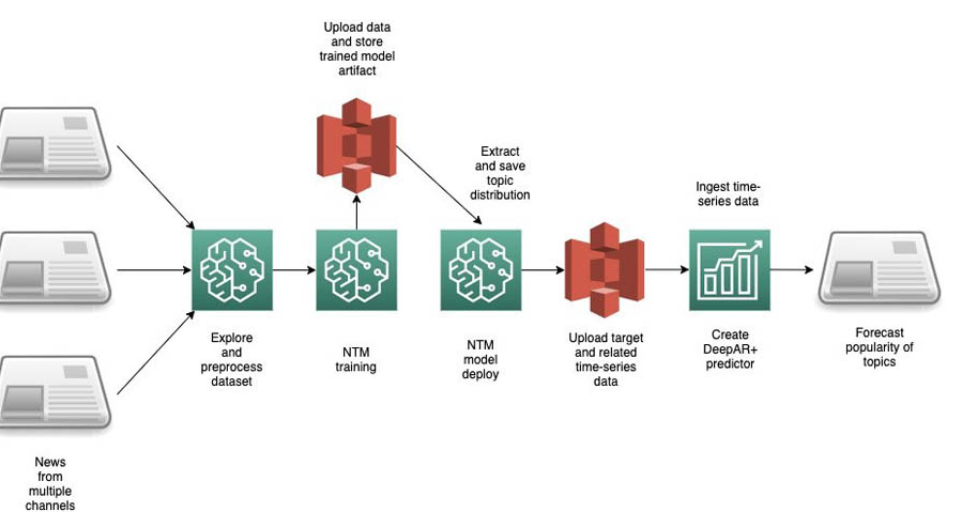

In [2]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_141552_9.png")

### AWS services

Forecast is a fully managed service that uses machine learning (ML) to generate highly accurate forecasts without requiring any prior ML experience. Forecast is applicable in a wide variety of use cases, including energy demand forecasting, estimating product demand, workforce planning, and computing cloud infrastructure usage.

With Forecast, there are no servers to provision or ML models to build manually. 

To use Forecast, you only need to provide historical data for what you want to forecast, and, optionally, any related data that you believe may impact your forecasts. This related data may include time-varying data (such as price, events, and weather) and categorical data (such as color, genre, or region). 

The service automatically trains and deploys ML models based on your data and provides you with a custom API to retrieve forecasts.

forecast는 기계 학습 (ML)을 사용하여 선행 ML 경험없이 매우 정확한 예측을 생성하는 완벽한 관리 서비스입니다. 예측은 에너지 수요 예측, 제품 수요, 인력 계획 및 컴퓨팅 클라우드 사용량을 포함한 다양한 케이스에 적용 가능합니다. 

forecast는 수동으로 구축 할 모델을 제공하거나 provision할 서버가 없습니다.

예측을 사용하려면 예측하려는 것에 대한 기록 데이터 만 제공하고 선택적으로 귀하의 예측에 영향을 미칠 수 있는 관련 데이터 만 제공해야합니다. 이 관련 데이터에는 시간적으로 변화하는 데이터 (예 : 가격, 이벤트 및 날씨) 및 범주 구성 데이터 (예 : 컬러, 장르 또는 지역)가 포함될 수 있습니다.

이 서비스는 데이터를 기반으로 ML 모델을 자동으로 훈련 및 배포하고 Ferecast를 검색 할 수 있는 사용자 지정 API를 제공합니다 

Amazon SageMaker is a fully managed service that provides every developer and data scientist with the ability to build, train, and deploy ML models quickly. 

The Neural Topic Model (NTM) algorithm is an unsupervised learning algorithm that can organize a collection of documents into topics that contain word groupings based on their statistical distribution. 

For example, documents that contain frequent occurrences of words such as “bike,” “car,” “train,” “mileage,” and “speed” are likely to share a topic on “transportation.” 

You can use topic modeling to classify or summarize documents based on the topics detected. You can also use it to retrieve information and recommend content based on topic similarities.

Amazon SageMaker는 ML 모델을 빠르게 빌드, 훈련 및 배포 할 수있는 성능을 모든 개발자 및 데이터 과학자에게 제공하는 완전히 관리되는 서비스입니다. 

NTM 알고리즘은 통계 분포를 기반으로 단어 그룹이 포함 된 주제으로 문서 모음을 구성 할 수 있는 비지도 학습 알고리즘입니다. 

예를 들어, "자전거", "자동차", "마일리지" 및 "속도"와 같은 단어가 자주 발생하는 문서가  "운송"에 대한 주제를 공유 할 수 있습니다. 

주제 모델링을 사용하여 탐지 된 주제를 기반으로 문서를 분류하거나 요약 할 수 있습니다. 

또한 이를 사용하여 정보를 검색하고 주제 유사성을 기반으로 콘텐츠를 추천 할 수 있습니다.

The derived topics that NTM learns are characterized as a latent representation because they are inferred from the observed word distributions in the collection. 

The semantics of topics are usually inferred by examining the top ranking words they contain. 

Because the method is unsupervised, only the number of topics, not the topics themselves, are pre-specified. In addition, the topics aren’t guaranteed to align with how a human might naturally categorize documents. 

NTM is one of the built-in algorithms you can train and deploy using Amazon SageMaker.

NTM Learns가 단어모음집에서 관찰 된 단어 분포에서 유추 되었기 때문에 주제의 의미는 일반적으로 그들이 포함하는 최고 순위 단어를 검토함으로써 추론됩니다. 

메소드가 비지도이기 때문에, 주제 자체가 아닌 주제의 수만 사전 지정됩니다. 

또한 주제는 인간이 자연스럽게 문서를 분류 할 수 있는 방법으로 정렬되는 것을 보장하지 않습니다. 

NTM은 Amazon SageMaker를 사용하여 훈련 및 배포 할 수있는 내장 알고리즘 중 하나입니다.


## DeepAR+ 알고리즘

출처 - [https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/aws-forecast-recipe-deeparplus.html](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/aws-forecast-recipe-deeparplus.html)

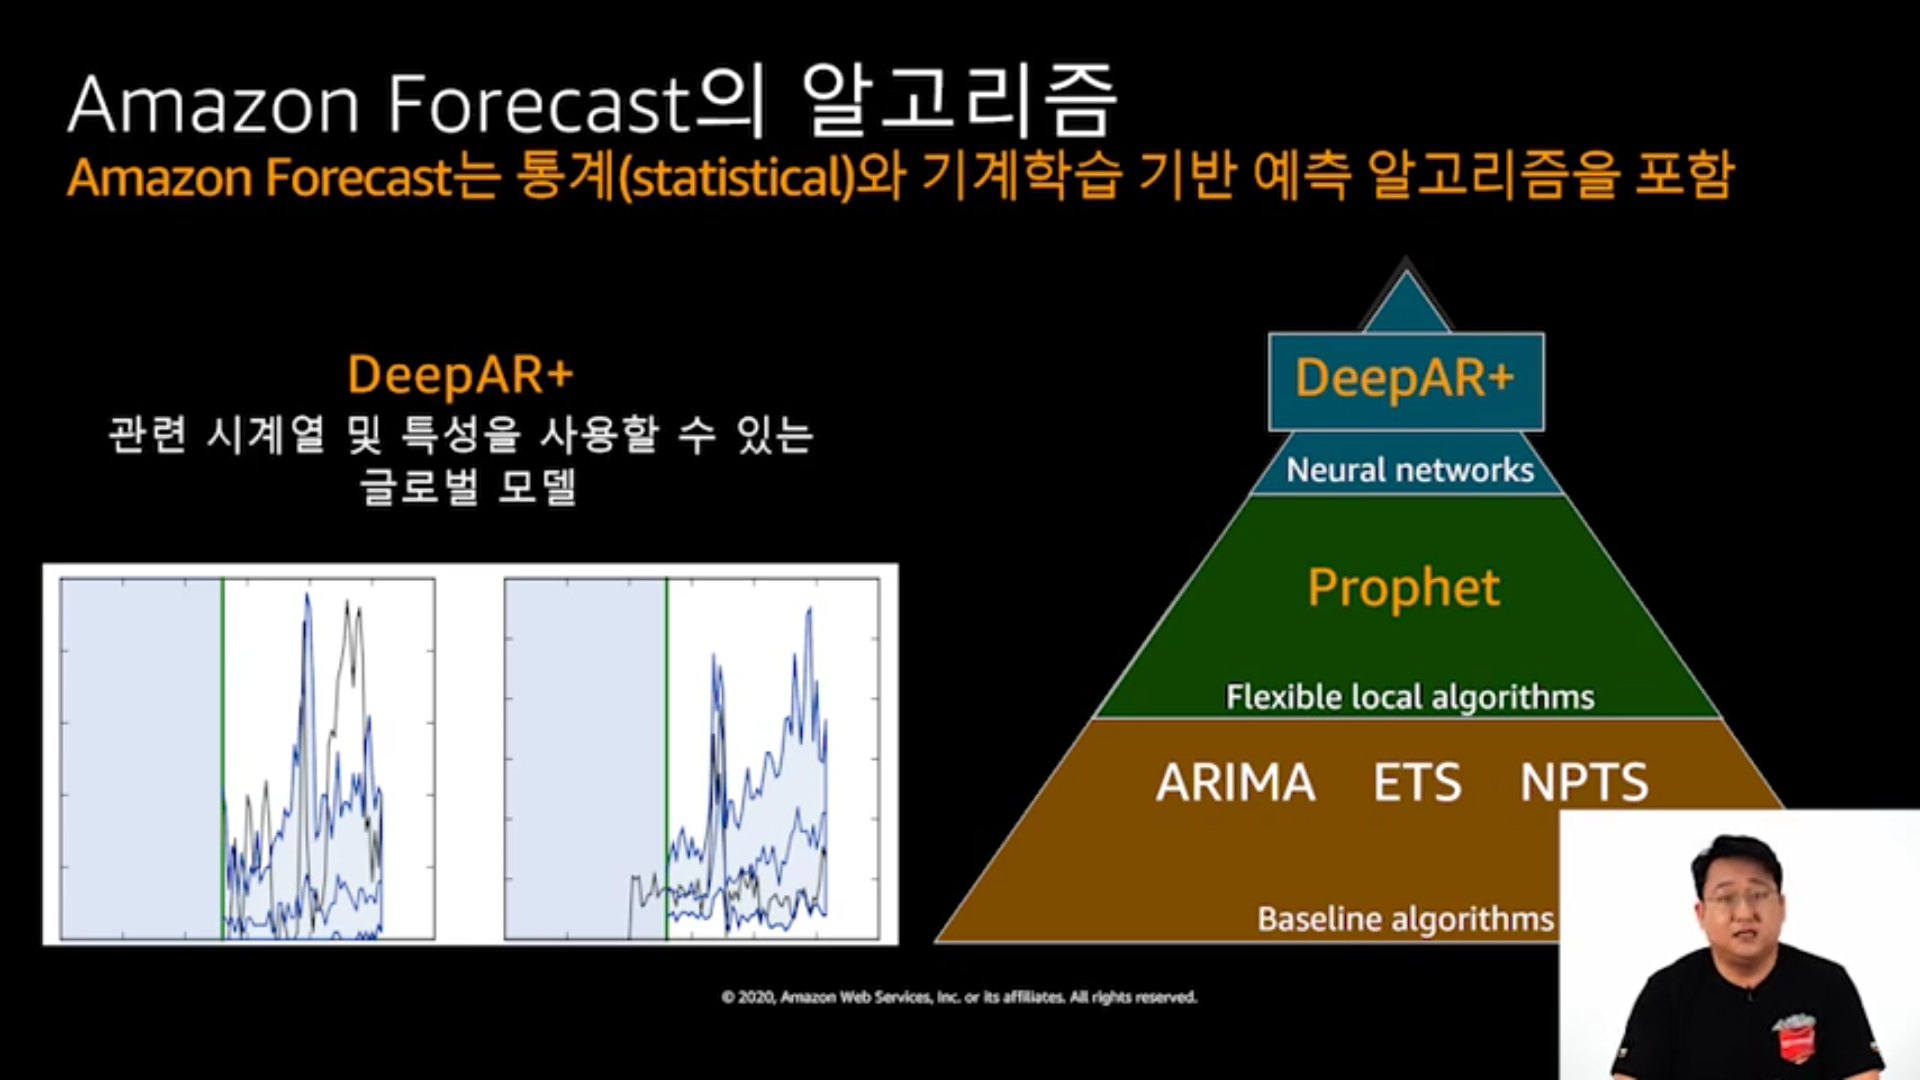

In [7]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_141552_4.png")

사진 출처 - [https://www.youtube.com/watch?v=XXIZQdzjVbs](https://www.youtube.com/watch?v=XXIZQdzjVbs)

Amazon Forecast를 통한 시계열 예측 활용하기 - 김종선, AWS 솔루션즈 아키텍트 :: AWS Innovate AI/ML 컨퍼런스 2020


Amazon Web Services Korea

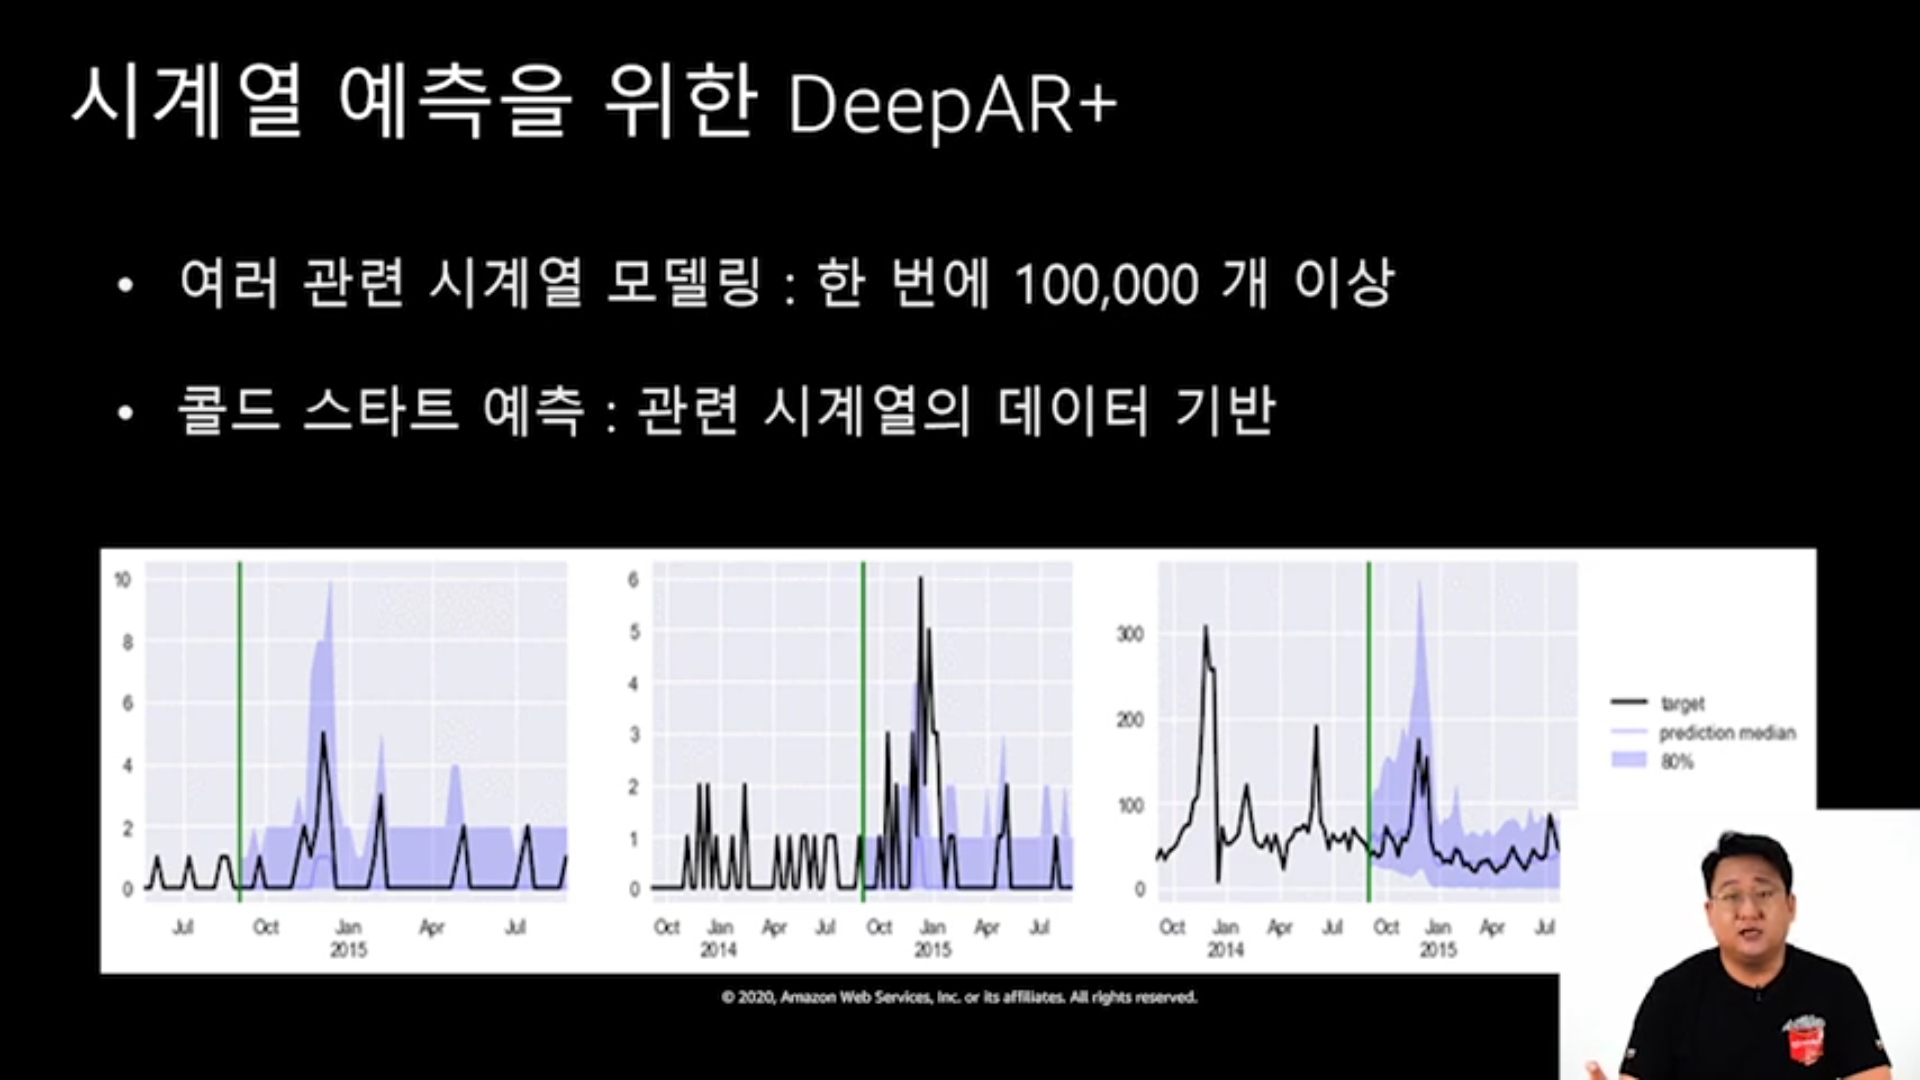

In [8]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_141552_5.png")

Amazon Forecast DeepAR+는 반복 신경망(RNN)을 사용하여 스칼라(1차원) 시계열을 예상하는 지도 학습 알고리즘입니다. Autoregressive Integrated Moving Average(ARIMA) 또는 Exponential Smoothing(ETS)과 같은 기존 예측 메서드는 각 시계열에 하나의 모델만이 맞고, 해당 모델을 사용하여 시계열의 미래를 추론합니다. 

그러나 많은 애플리케이션에서 일련의 횡단적 단위에 걸쳐 비슷한 시계열이 많이 있습니다. 이러한 시계열 그룹화에는 다양한 제품, 서버 로드 및 웹 페이지에 대한 요청이 필요합니다. 이러한 경우 단일 모델을 모든 시계열과 결합하여 교육하는 것이 이득이 될 수 있습니다. DeepAR+는 이러한 접근 방법을 사용합니다. 데이터 세트에 수백 개의 기능 시계열이 포함되어 있는 경우, DeepAR+ 알고리즘이 표준 ARIMA 및 ETS 방법보다 우수합니다. 또한 교육을 받은 모델과 유사한 새 시계열에 대해 예상을 발생하기 위해 교육받은 모델을 사용할 수도 있습니다.

### 활용사례

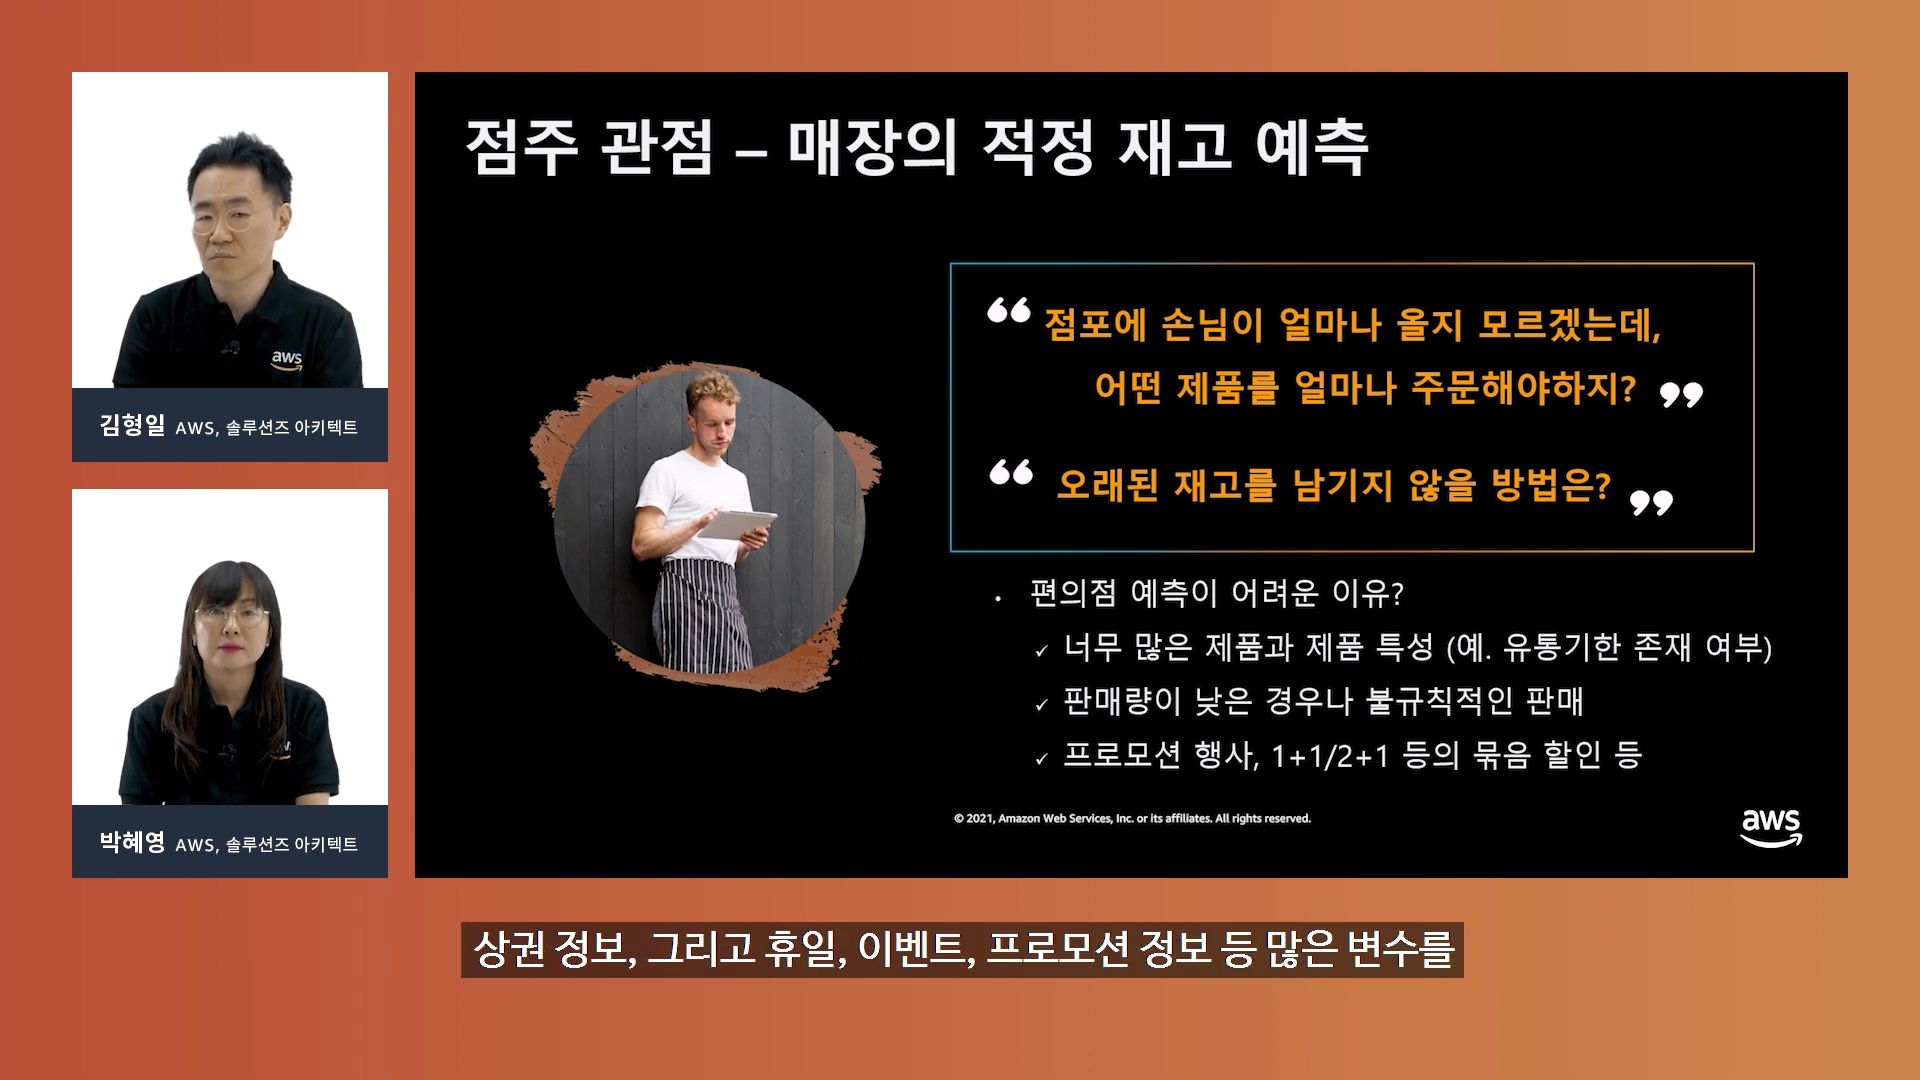

In [14]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_170503_1.png")


사진 출처 : https://www.youtube.com/watch?v=AHEO_KGQJwU

Amazon Forcast를 통한 급성장하는 리테일 기업의 시계열 예측 – 김형일, 박혜영:: AWS Innovate 2021

Amazon Web Services Korea

>1. 신선한 농산물 카테고리 예측의 복잡성

>> 신선한 제품은 유통 기한이 짧기 때문에 신선한 농산물 카테고리에 대한 수요를 예측하는 것은 어렵습니다. 과도한 예측을 통해 상점은 오래되거나 과도하게 익은 제품을 판매하거나 대부분의 재고를 폐기합니다 ( 수축 이라고 함 ). 예상치 못한 경우 제품이 품절되어 고객 경험에 영향을 미칠 수 있습니다. 고객은 쇼핑 목록에서 주요 품목을 찾을 수없는 경우 장바구니를 포기할 수 있습니다. 몇 가지 제품에 대해 계산대에서 기다리는 것을 원하지 않기 때문입니다. 이러한 복잡성을 추가하기 위해 MRL은 600 개가 넘는 슈퍼마켓에 걸쳐 많은 SKU를 보유하고있어 6,000 개 이상의 상점 -SKU 조합으로 이어집니다.
2019 년 말까지 MRL은 기존 통계 방법을 사용하여 각 매장 -SKU 조합에 대한 예측 모델을 생성하여 정확도가 40 %까지 낮아졌습니다. 예측은 여러 개별 모델을 통해 유지되므로 계산 및 운영 비용이 많이 듭니다.
 

 

>2. 주문 배치에 대한 수요 예측

>> 2020 년 초, MRL과 Ganit은 과일 및 채소 (F & V)라고하는 신선한 카테고리를 예측하는 정확도를 더욱 높이고 수축을 줄이기 위해 협력하기 시작했습니다.Ganit은 MRL에게 문제를 두 부분으로 나누라고 조언했습니다.
각 상점 -SKU 조합에 대한 수요 예측
주문 수량 계산 (들여 쓰기)
다음 섹션에서 각 항목에 대해 자세히 설명하겠습니다. 

 

 

>3. 수요 예측

>> 이 섹션에서는 각 상점 -SKU 조합에 대한 수요 예측 단계에 대해 설명합니다.
 


>>3.1 수요 요인 이해

>>Ganit의 팀은 먼저 매장 내에서 수요를 유도 한 요인을 이해함으로써 여정을 시작했습니다. 여기에는 여러 현장 매장 방문, 카테고리 관리자와의 토론, 슈퍼마켓 CEO와의 케이던스 회의와 계절성, 재고 부족, 사회 경제적, 거시 경제적 요인과 같은 여러 다른 측면에 대한 Ganit의 자체 예측 전문 지식이 포함되었습니다. 

>> 매장 방문 후 다양한 요인에 대한 약 80 개의 가설이 식음료 ​​수요에 미치는 영향을 연구하기 위해 공식화되었습니다. 팀은 상관 관계, 이변 량 및 일 변량 분석, 통계적 유의성 테스트 (학생 t- 검정, Z 테스트)와 같은 기술을 사용하여 포괄적 인 가설 테스트를 수행하여 수요와 축제 날짜, 날씨, 프로모션 등과 같은 관련 요소 간의 관계를 설정했습니다.
 

 

4. 데이터 분류

팀은 매일 매장 -SKU 조합을 정확하게 예측할 수있는 세분화된 모델 개발을 강조했습니다. 매출 기여도와 예측 용이성의 조합은 ABC-XYZ 프레임 워크로 구축되었으며, ABC는 매출 기여도를 나타내고 (A는 가장 높음) XYZ는 예측 용이성을 나타냅니다 (Z는 가장 낮음). 모델 구축의 경우 첫 번째 초점은 매출 기여도가 높고 예측하기 가장 어려운 상점 -SKU 조합이었습니다. 이는 예측 정확도 향상이 비즈니스에 최대의 영향을 미치도록하기위한 것입니다.
 

 

5. 데이터 처리

MRL의 거래 데이터는 휴대폰 번호, 청구서 번호, 품목 코드, 상점 코드, 날짜, 청구 수량, 실현 가치 및 할인 가치와 같은 필드를 사용하여 기존의 POS 데이터처럼 구성되었습니다. 팀은 모델 구축을 위해 지난 2 년 동안의 일일 트랜잭션 데이터를 사용했습니다. 과거 데이터를 분석하면 두 가지 문제를 식별하는 데 도움이되었습니다.
수많은 결 측값의 존재
어떤 날에는 청구서 수준에서 판매량이 매우 높거나 낮았으며 데이터에 특이 치가 있음을 나타냅니다.
 

 

- 누락된 값 처리

누락 된 값에 대한 심층 분석을 통해 매장에 재고가 없거나 (계절에 공급되지 않음), 계획된 휴일 또는 외부 제약 (예 : 지역 또는 전국 폐쇄 또는 건설 작업)으로 인해 폐쇄되는 매장과 같은 이유를 식별했습니다. 누락 된 값은 0으로 대체되고 적절한 회귀 변수 또는 플래그가 모델에 추가되어 모델이 이러한 미래 이벤트에 대해 이를 학습 할 수 있습니다.
 

- 이상 값 처리

팀은 가장 세분화 된 청구서 수준에서 이상 값을 처리하여 청산, 대량 구매 (B2B) 및 나쁜 품질과 같은 요소를 고려했습니다. 예를 들어, 청구서 수준 처리에는 다음 그래프와 같이 일 수준에서 각 상점 -SKU 조합에 대한 KPI를 관찰하는 것이 포함될 수 있습니다.

####  예측 프로세스

팀은 Forecast를 선택하기 전에 시계열 모델, 회귀 기반 모델 및 딥 러닝 모델과 같은 여러 예측 기술을 테스트했습니다. 예측을 선택하는 주된 이유는 XY 버킷의 예측 정확도를 Z 버킷과 비교할 때 성능 차이 였기 때문에 예측하기 가장 어려웠습니다. 대부분의 기존 기술이 XY 버킷에서 더 높은 정확도를 제공했지만 Forecast의 ML 알고리즘 만이 다른 모델에 비해 10 %의 증가 정확도를 제공했습니다. 이는 주로 다른 SKU (XY) 패턴을 학습하고 이러한 학습을 ​​Z 버킷의 변동성이 높은 항목에 적용하는 Forecast의 기능 때문이었습니다. AutoML을 통해 Forecast DeepAR + 알고리즘이 승자이며 예측 모델로 선택되었습니다.

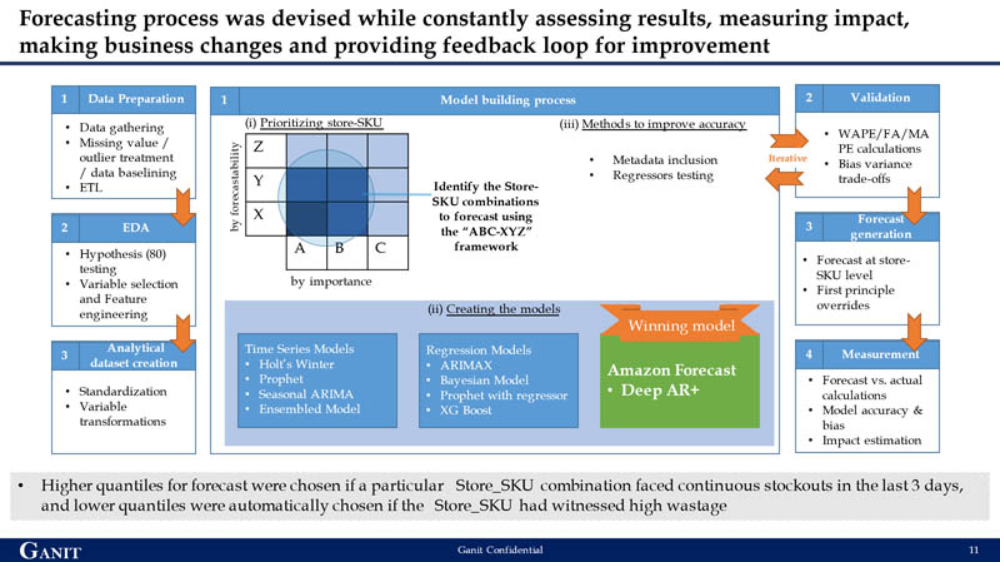

In [15]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_172051_1.png")


- 예측 정확도를 더욱 향상시키기 위해 반복

팀은 Deep AR +를 우승 알고리즘으로 식별 한 후 정확도를 더욱 향상시키기 위해 추가 기능을 사용하여 여러 실험을 실행했습니다. 그들은 순수한 목표 시계열 데이터 (이상 값 처리 포함 및 제외), 축제 또는 상점 폐쇄와 같은 회귀 자, 상점 항목 메타 데이터 (상점 항목 계층 구조)와 같은 다양한 조합을 사용하여 더 작은 샘플 세트에서 여러 반복을 수행하여 최적의 조합을 이해했습니다. 예측 정확도 향상. 이상치 처리 대상 시계열과 상점 항목 메타 데이터 및 회귀 변수의 조합이 가장 높은 정확도를 반환했습니다. 이는 최종 예측을 얻기 위해 원래 6,230 개의 상점 -SKU 조합 세트로 축소되었습니다.

- 출처 : [https://www.megazone.com/techblog-20210315-from-forecasting-demand-to-ordering-an-automated-machine-learning-approach-with-amazon-forecast-to-decrease-stock-outs-excess-inventory-and-costs/](https://www.megazone.com/techblog-20210315-from-forecasting-demand-to-ordering-an-automated-machine-learning-approach-with-amazon-forecast-to-decrease-stock-outs-excess-inventory-and-costs/)

수요 예측에서 주문까지 – 재고 부족, 초과 재고 및 비용을 줄이기위한 Amazon Forecast의 자동화 된 기계 학습 접근 방식




### 기술적인 방식의 접근

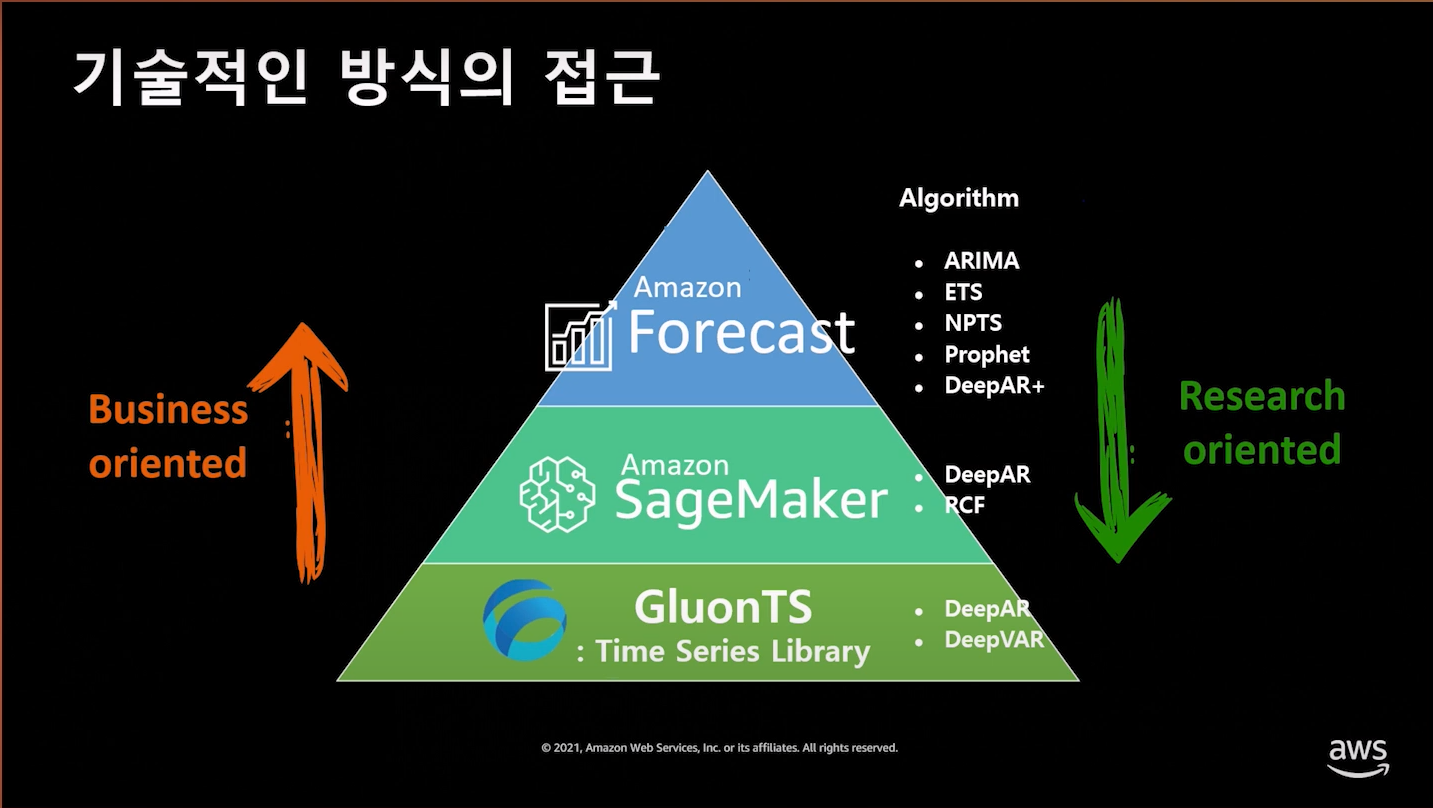

In [11]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_170503_2.png")


사진 출처 : https://www.youtube.com/watch?v=AHEO_KGQJwU

Amazon Forcast를 통한 급성장하는 리테일 기업의 시계열 예측 – 김형일, 박혜영:: AWS Innovate 2021

Amazon Web Services Korea

Amazon SageMaker는 분산 컴퓨팅 인프라를 관리하고, 모델 학습 작업을 모니터링 및 디버깅하는 “높은 부담의 작업”을 줄여 고객 문제를 해결하는 완전 관리형 기계 학습 플랫폼입니다. SageMaker 데이터 병렬 처리 라이브러리와 Amazon SageMaker 디버거 를 사용하여 현대자동차의 기술적 과제를 해결하고 비용 효율적으로 비즈니스 목표를 달성할 수 있었습니다.

SageMaker는 데이터 병렬 처리 및 모델 병렬 처리를 위한 분산 학습 라이브러리를 제공합니다. 이 경우, 학습중인 모델은 단일 GPU의 메모리에 맞더라도 학습 데이터의 양이 클 경우 학습 시간이 너무 오래 걸립니다. 이런 경우, 데이터 병렬 분산 학습을 사용하면 학습 작업의 전체 시간을 줄일 수 있습니다. SageMaker 데이터 병렬 처리는 학습 데이터를 여러 GPU 인스턴스로 분산하고 할당 된 데이터 세트를 사용하여 각 GPU에서 동일한 모델을 학습합니다. SageMaker 데이터 병렬 처리 라이브러리는 더 많은 GPU를 사용하면서 거의 선형에 가까운 확장성을 제공하는 고속 AWS 네트워크 인프라를 활용하도록 설계되었습니다.

이번에 사용한 모델 학습 아키텍처에서는 Amazon SageMaker를 사용하고, 일시 데이터 저장을 위해 Amazon FSx for Lustre, 영구적인 데이터 저장에 Amazon S3서비스를 활용합니다. PyTorch 기반의 모델 학습을 데이터 병렬 처리 라이브러리을 활용하여 단 몇 줄의 학습 코드만으로 8개의 GPU 인스턴스 또는 총 64개의 GPU를 사용

단일 GPU를 사용하여 모델을 학습하는 것과는 다르게, 다중 또는 분산 GPU 학습에서는 단일 GPU에서 관찰되지 않은 성능 문제가 나타날 수 있습니다. 따라서, 고가의 GPU 리소스를 최대한 활용하고 원하는 모델 성능을 달성하려면 학습 지표와 함께 리소스 사용률을 모니터링하는 것이 중요합니다.

Amazon SageMaker 디버거 및 프로파일링 기능을 통해 딥 러닝 과학자 및 엔지니어는 학습 작업이 실행되는 동안에 시스템 관련 또는 모델 관련 성능 문제를 모니터링, 추적 및 분석 할 수 있습니다. 디버깅 출력을 활성화하기 위해서 학습 코드를 변경할 필요가 없습니다. 실시간 모니터링 및 시각화는 Amazon SageMaker Studio 에서 제공하며, 커스텀 시각화 또는 분석을 위한 API 호출을 통해 수집된 디버깅 및 프로파일링 데이터를 액세스 할 수 있습니다. 진행 중인 학습이 진행되고 있는 중에 SageMaker 프로파일러를 켜거나 끄고, 또는 프로파일링 구성을 변경하여 디버거의 프레임워크 수준 프로파일링 기능으로 인한 부하를 최소화 하는 것도 가능합니다.

- 글 출처 : [https://aws.amazon.com/ko/blogs/korea/hyundai-reduces-training-time-for-autonomous-driving-models-using-amazon-sagemaker/](https://aws.amazon.com/ko/blogs/korea/hyundai-reduces-training-time-for-autonomous-driving-models-using-amazon-sagemaker/)
    
현대자동차, Amazon SageMaker 기반 자율 주행 기계 학습 모델의 학습 시간 단축 사례

> segemaker 도입효과 


- 글 출처 : SageMaker을 활용한 인공지능 서비스 자동화 사례 (나재원, 마이셀럽 CTO) :: AWS TechShift 2018

[https://www.slideshare.net/awskorea/sagemaker-120813207](https://www.slideshare.net/awskorea/sagemaker-120813207)

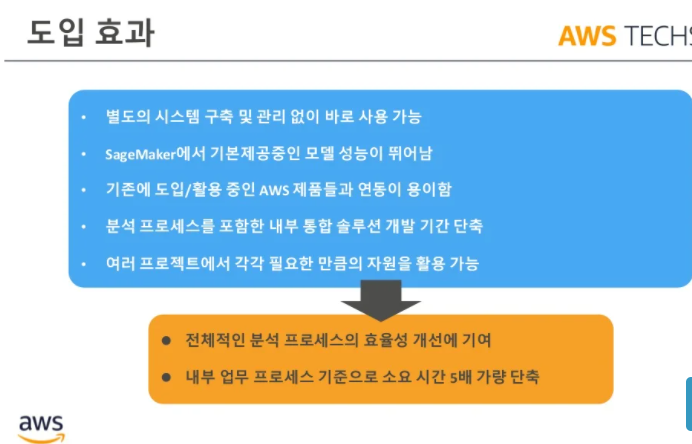

In [18]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220221_175140_1.png")
